In [42]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F


In [43]:
class ActorCritic(nn.Module):
    def __init__(self, state_space,
                 action_space):
        super(ActorCritic, self).__init__()

        
        self.Linear1 = nn.Linear(state_space, 128)
        self.actor = nn.Linear(128, action_space)
        self.critic=nn.Linear(128, 1)
        self.softmax = nn.Softmax(dim=0)
   
    def forward(self, x):
        
        x = F.relu(self.Linear1(x))
        actor = self.actor(x)
        actor = self.softmax(actor)
        critic=self.critic(x)
        
        return actor,critic

In [44]:
def selct_action(state,Q_net):
    action_prob,_=Q_net(state)
    action = np.random.choice(np.array([0,1]), p=action_prob.data.numpy())
    
    return action

In [45]:
def generate_trajectory(env,neural_net, n_steps=1000):
        """
        Play a session and genrate a trajectory
        returns: arrays of states, actions, rewards
        """
        states, actions, rewards = [], [], []
        # initialize the environment
        s1 = env.reset()[0]
        s=torch.FloatTensor(s1)
        #generate n_steps of trajectory:
        for t in range(n_steps):
            act=selct_action(s,neural_net)
            next_state1, r, done, info,_= env.step(act)
            next_state=torch.FloatTensor(next_state1)
            #update arrays
            states.append(s1)
            actions.append(act)
            rewards.append(r)

            s = next_state
            s1= next_state1
            if done:
                break
        return states, actions, rewards

In [46]:
def get_rewards_to_go(rewards, gamma=0.99):
        T = len(rewards) # total number of individual rewards
        # empty array to return the rewards to go
        rewards_to_go = [0]*T
        rewards_to_go[T-1] = rewards[T-1]
        for i in range(T-2, -1, -1): #go from T-2 to 0
            rewards_to_go[i] = gamma * rewards_to_go[i+1] + rewards[i]
        return rewards_to_go

In [55]:
def log_ten(states,num_action,Q_net):
    T=torch.zeros(states.shape[0],num_action)
    for i,s in enumerate(states):
        actor,_=Q_net(s)
        T[i]=actor
    return T

In [58]:
def train_one_episode(states,Q_net,num_action,actions, rewards, gamma=0.99, entropy_coef=1e-2):
    rewards_to_go = get_rewards_to_go(rewards, gamma)
    states = torch.FloatTensor(states)
    actions=torch.LongTensor(actions)
    rewards_to_go = torch.FloatTensor(rewards_to_go)
    
    _, state_values = Q_net(states)
    
    # get log action probabilities from states
    Soft_max_actions=log_ten(states,num_action,Q_net)
    log_probs = torch.log(Soft_max_actions)
    log_probs_for_actions = log_probs[range(len(actions)), actions]
    
    advantage = rewards_to_go - state_values.squeeze(-1)
    
  #Compute loss to be minized
    J = torch.mean(log_probs_for_actions*(advantage))
    H = -(Soft_max_actions*log_probs).sum(-1).mean()
    loss = -(J+entropy_coef*H)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return np.sum(rewards)

In [60]:
env=gym.make("CartPole-v1")
num_states=env.observation_space.shape[0]
num_actions=env.action_space.n
Q = ActorCritic(state_space=num_states, 
             action_space=num_actions)
optimizer = torch.optim.Adam(Q.parameters(), lr=1e-3)

total_rewards = []
mean_reward_l=[]
for i in range(2000):
    states, actions, rewards = generate_trajectory(env,Q)
    reward = train_one_episode(states,Q,num_actions,actions, rewards)
    total_rewards.append(reward)
    if i != 0 and i % 100 == 0:
        mean_reward = np.mean(total_rewards[-100:-1])
        mean_reward_l.append(mean_reward )
        print("mean_reward: {}, iteration: {}".format(mean_reward, i))
        
env.close()

mean_reward: 24.757575757575758, iteration: 100
mean_reward: 40.05050505050505, iteration: 200
mean_reward: 91.42424242424242, iteration: 300
mean_reward: 172.37373737373738, iteration: 400
mean_reward: 291.95959595959596, iteration: 500
mean_reward: 378.95959595959596, iteration: 600
mean_reward: 708.6161616161617, iteration: 700
mean_reward: 564.6565656565657, iteration: 800
mean_reward: 810.7070707070707, iteration: 900
mean_reward: 877.1717171717172, iteration: 1000
mean_reward: 938.4545454545455, iteration: 1100
mean_reward: 976.020202020202, iteration: 1200
mean_reward: 963.070707070707, iteration: 1300
mean_reward: 914.8181818181819, iteration: 1400
mean_reward: 914.3838383838383, iteration: 1500
mean_reward: 999.2323232323232, iteration: 1600
mean_reward: 517.1111111111111, iteration: 1700
mean_reward: 942.939393939394, iteration: 1800
mean_reward: 1000.0, iteration: 1900


In [94]:
av_re=[]
for i in range(len(mean_reward_l)):
    for b in [mean_reward_l[i]]*100:
        av_re.append(b)
    

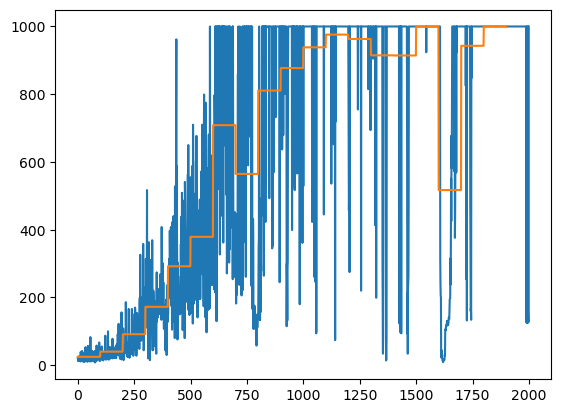

In [96]:
plt.plot(total_rewards)

plt.plot(av_re)

In [ ]:
done=False
env=gym.make("CartPole-v1", render_mode="human")
t=0
while not done:
    obs=env.reset()[0]
    
    obs=torch.tensor(obs)
    opt_policy = selct_action(obs,Q)
    next_state, reward, done, _,_ = env.step(opt_policy)
    env.render()
    obs=next_state
    t=t+1
    if t>=250:
        break
env.close()  

In [63]:
mean_reward_l*100

[24.757575757575758,
 40.05050505050505,
 91.42424242424242,
 172.37373737373738,
 291.95959595959596,
 378.95959595959596,
 708.6161616161617,
 564.6565656565657,
 810.7070707070707,
 877.1717171717172,
 938.4545454545455,
 976.020202020202,
 963.070707070707,
 914.8181818181819,
 914.3838383838383,
 999.2323232323232,
 517.1111111111111,
 942.939393939394,
 1000.0,
 24.757575757575758,
 40.05050505050505,
 91.42424242424242,
 172.37373737373738,
 291.95959595959596,
 378.95959595959596,
 708.6161616161617,
 564.6565656565657,
 810.7070707070707,
 877.1717171717172,
 938.4545454545455,
 976.020202020202,
 963.070707070707,
 914.8181818181819,
 914.3838383838383,
 999.2323232323232,
 517.1111111111111,
 942.939393939394,
 1000.0,
 24.757575757575758,
 40.05050505050505,
 91.42424242424242,
 172.37373737373738,
 291.95959595959596,
 378.95959595959596,
 708.6161616161617,
 564.6565656565657,
 810.7070707070707,
 877.1717171717172,
 938.4545454545455,
 976.020202020202,
 963.070707070707